In [13]:
# Enable autoreload of module
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import torch
import torchvision
from vector_quantize_pytorch import VectorQuantize
import os
from data.neural_field_datasets import MnistNeFDataset, TokenTransform
from training import training_nano_gpt

from networks.nano_gpt import GPTConfig

torch.cuda.is_available()

True

In [15]:
kwargs = {
"type": "pretrained",
"fixed_label": None,
}

dir_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(dir_path, "adl4cv")

# load used vector quantizer
vq_dicts = torch.load(os.path.join(data_root, "models", "vqs", "vq_mnist_with_all_5_conditioned_n_501.pt"))
vq = VectorQuantize(**vq_dicts["vq_config"])
vq.load_state_dict(vq_dicts["state_dict"])

<All keys matched successfully>

In [18]:
dataset = MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), transform=TokenTransform(vq), **kwargs)
len(dataset)

60000

In [19]:
# Config Training
config = training_nano_gpt.Config()
config.learning_rate=3e-3
config.max_iters = 30000
config.weight_decay=0.00
config.decay_lr=True
config.lr_decay_iters=config.max_iters
config.warmup_iters=0.05*config.max_iters
config.batch_size = 64
config.gradient_accumulation_steps = 1
config.init_from = "scratch"
config.out_dir ="models/token_transformer"
config.detailed_folder = "training_sample_5"
config.eval_interval = 250
config.metric_interval = 250

model_config = GPTConfig(n_embd=180, block_size=len(dataset[0][0]) + 1, n_head=12, n_layer=12, vocab_size=vq_dicts["vq_config"]["codebook_size"] + 11, dropout=0.0, max_len=len(dataset[0][0]) + 1)

loaded = torch.load("./models/token_transformer/N_ALL_5M_LARGE_GOOD.pth")
model_config = loaded["model_args"]
config = loaded["config"]

In [20]:
182%12

2

In [21]:
#early_stopping = training_nano_gpt.EarlyStopper(20)

In [22]:
"""model_config = GPTConfig(
    n_embd=120, 
    block_size=len(dataset[0][0]), 
    n_head=12, n_layer=6, 
    vocab_size=vq_dicts["vq_config"]["codebook_size"] + 1,
    dropout=0.0
    )"""

'model_config = GPTConfig(\n    n_embd=120, \n    block_size=len(dataset[0][0]), \n    n_head=12, n_layer=6, \n    vocab_size=vq_dicts["vq_config"]["codebook_size"] + 1,\n    dropout=0.0\n    )'

In [23]:
cb_size = vq_dicts["vq_config"]["codebook_size"]
token_dict = {
    "SOS": cb_size + 0,
    "0": cb_size + 10,
    "1": cb_size + 9,
    "2": cb_size + 8,
    "3": cb_size + 7,
    "4": cb_size + 6,
    "5": cb_size + 5,
    "6": cb_size + 4,
    "7": cb_size + 3,
    "8": cb_size + 2,
    "9": cb_size + 1
}


In [24]:
token_dict, cb_size

({'SOS': 245,
  '0': 255,
  '1': 254,
  '2': 253,
  '3': 252,
  '4': 251,
  '5': 250,
  '6': 249,
  '7': 248,
  '8': 247,
  '9': 246},
 245)

In [25]:
# Where to put?
# Maybe adjust dataset to be able to work with splitting data and then rewrite TokenTransform 
# to do the job combined with pytorch dataloader (get_batch == __call__ of Dataloader)

def create_split_indices(n, train_ratio=0.9):
    # Generate a random permutation of indices from 0 to n-1
    shuffled_indices = torch.randperm(n)
    # Determine the cut-off for training data
    train_size = int(train_ratio * n)
    # Split indices into training and validation sets
    train_indices = shuffled_indices[:train_size]
    val_indices = shuffled_indices[train_size:]
    return train_indices, val_indices

train_indices, val_indices = create_split_indices(len(dataset))

def get_batch_lambda(config, dataset, model_config, split):
    batch_size = config.batch_size
    

    # Select indices based on the split
    if split == 'train':
        # Randomly select batch_size indices from the train_indices
        indices = train_indices[torch.randint(0, len(train_indices), (batch_size,))]
    elif split == 'val':
        # Randomly select batch_size indices from the val_indices
        indices = val_indices[torch.randint(0, len(val_indices), (batch_size,))]
    
    
    # Initialize lists to hold the sequences and labels
    samples = []
    labels = []

    # Collect samples and labels
    for idx in indices:
        sample, label = dataset[idx]
        start_tokens = torch.Tensor([token_dict["SOS"], token_dict[str(label)]]).long()  # Start of sequence token
        sample = torch.cat((start_tokens, sample), dim=0)
        #start_tokens = torch.Tensor([0]).long()  # Start of sequence token
        #sample = torch.cat((start_tokens, sample + 1), dim=0)
        samples.append(sample)
        labels.append(label)

    # Prepare the sequences for model input
    max_len = samples[0].size(0)
    x = torch.zeros((batch_size, max_len - 1), dtype=torch.long)
    y = torch.zeros((batch_size, max_len - 1), dtype=torch.long)
    
    for i, sample in enumerate(samples):
        end_index = sample.size(0) - 1
        x[i, :end_index] = sample[:-1]  # Exclude the last token for x
        y[i, :end_index] = sample[1:]   # Exclude the first token for y

    # Ensure x and y are the correct shape (batch_size, block_size) if needed:
    # Here, we truncate to `block_size` if samples are longer than `block_size`.
    x = x[:, :model_config.block_size]
    y = y[:, :model_config.block_size]

    # x and y have to be
    x = x.to(config.device)
    y = y.to(config.device)

    return x, y

create_get_batch = lambda config, dataset, model_config: lambda split: get_batch_lambda(config, dataset, model_config, split)
get_batch = create_get_batch(config, dataset, model_config)

In [26]:
len(train_indices)*dataset[0][0].shape[0]

30294000

In [26]:
# Prepeare model parameters and train
import wandb
trained_model = training_nano_gpt.train(get_batch, config, model_config, vq, vq_dicts["vq_config"], token_dict=token_dict)


Initializing a new model from scratch
number of parameters: 5.62M
num decayed parameter tensors: 34, with 5,725,680 parameters
num non-decayed parameter tensors: 66, with 25,440 parameters
using fused AdamW: True


step 0: mnist classifier loss: 4.148148059844971, mnist accuracy: 0.09375
step 0: train loss 5.6732, val loss 5.6733
step 250: mnist classifier loss: 3.7687907218933105, mnist accuracy: 0.1875
step 250: train loss 3.6009, val loss 3.5888
saving checkpoint to models/token_transformer
step 500: mnist classifier loss: 4.303024768829346, mnist accuracy: 0.09375
step 500: train loss 3.5206, val loss 3.5355
saving checkpoint to models/token_transformer
step 750: mnist classifier loss: 4.295627593994141, mnist accuracy: 0.109375
step 750: train loss 3.4429, val loss 3.4496
saving checkpoint to models/token_transformer
step 1000: mnist classifier loss: 3.656226396560669, mnist accuracy: 0.25
step 1000: train loss 3.3417, val loss 3.3356
saving checkpoint to models/token_transformer
step 1250: mnist classifier loss: 3.9164624214172363, mnist accuracy: 0.15625
step 1250: train loss 3.1918, val loss 3.1861
saving checkpoint to models/token_transformer
step 1500: mnist classifier loss: 3.454338073

In [27]:
import matplotlib.pyplot as plt
import torch
from networks.nano_gpt import GPT
from utils import get_default_device

model_dict = torch.load("./models/token_transformer/proper_tokens.pt")
# Configuration
print(model_dict.keys())
idx = 3

device = get_default_device()
model = GPT(model_dict["model_args"])#model_dict
model.to(device=device)
model.load_state_dict(model_dict["model"])
model.eval()

vq = VectorQuantize(**model_dict["vq_config"])
vq.load_state_dict(model_dict["vq_state_dict"])
vq.eval()

dataset = MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), transform=TokenTransform(vq), **kwargs)


sample = dataset[0][0]
X, Y = get_batch('val')
X, Y = (X[0].unsqueeze(0), Y[0].unsqueeze(0))
pred, _ = model(X, Y)
# Sanity Check
# Should be all true except first/second element
pred.argmax(dim=-1)==Y


dict_keys(['model', 'optimizer', 'model_args', 'iter_num', 'best_val_loss', 'config', 'vq_state_dict', 'vq_config', 'token_dict'])
number of parameters: 5.62M


tensor([[False, False, False, False, False, False, False,  True, False,  True,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False,  True, False, False,  True,  True, False, False,
         False, False, False,  True, False,  True,  True,  True, False,  True,
          True, False,  True, False,  True,  True,  True, False, False, False,
         False,  True, False, False,  True, False,  True, False, False, False,
         False, False, False, False, False, False, False, False,  True, False,
         False, False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
          True, False,  True, False,  True, False, F

5
7
0
7
4
6
8
4
1


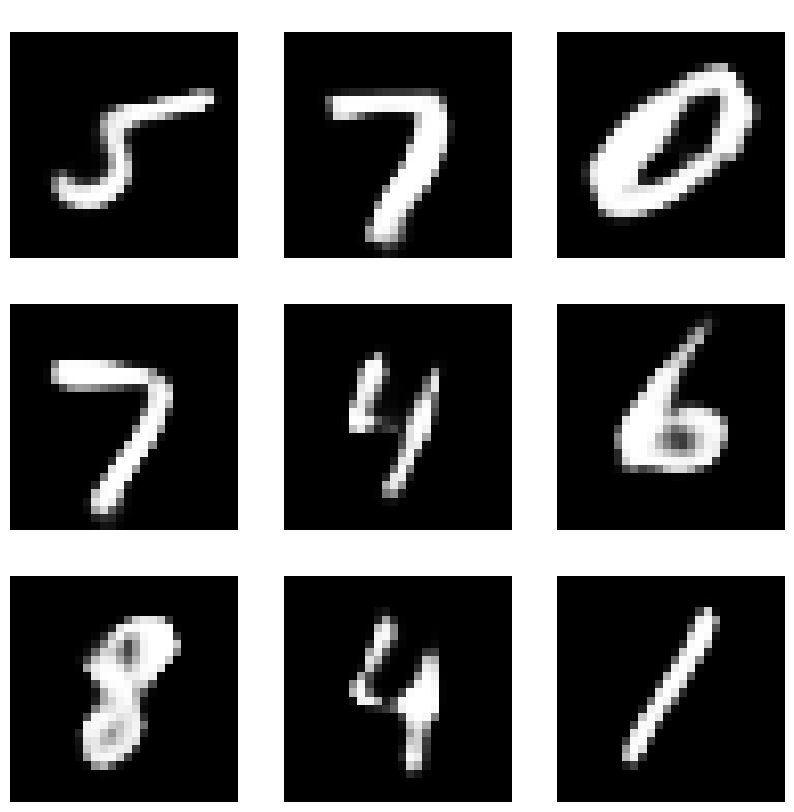

In [27]:
from random import randint
from animation.util import backtransform_weights, reconstruct_image
from networks.mlp_models import MLP3D

ij_len = 3
# Plotting the tensors as heatmaps in grayscale
plt.style.use("dark_background")
fig, axes = plt.subplots(ij_len, ij_len, figsize=(10, 10))

fig.patch.set_alpha(0)

for ax in axes.flat:
    ax.patch.set_facecolor("none")
    ax.patch.set_alpha(0)


kwargs = {
"type": "pretrained",
"fixed_label": None,
}

for i in range(ij_len):
    for j in range(ij_len):

        model.eval()
        number = str(randint(0, 9))
        novel_tokens = model.generate(torch.Tensor([[token_dict["SOS"], token_dict[number]]]).long().to(device="cuda"), dataset[0][0].shape[0], temperature=0.8, top_k=3)[:, 1:]

        print(number)
        novel_tokens = novel_tokens[:, 1:].unsqueeze(-1).to("cpu")
                                                                                                                         

        max_similarity = 0
        """
        for data in dataset:
            similarity = (data[0].to(device)==noxmarty/resnet-tiny-mnist
                max_similarity = similarity
        """
        #print(f"Maximum Similarity of picture (i, j) {(i, j)}: {max_similarity}")

        novel_weights= vq.get_codes_from_indices((novel_tokens))

        dataset_no_transform = MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), **kwargs)
        original_dict = dataset_no_transform[0][0]

        reconstructed_dict = backtransform_weights(novel_weights, original_dict["state_dict"])

        mlp3d = MLP3D(**original_dict["model_config"])
        mlp3d.load_state_dict(reconstructed_dict)
        reconstructed_tensor = reconstruct_image(mlp3d)

        axes[i][j].imshow(reconstructed_tensor, cmap='gray', aspect='auto')
        axes[i][j].set_title(number)
        axes[i][j].axis("off")

fig.patch.set_alpha(0)


plt.show()

In [38]:
# Create a Tensor for every possible label with all of mnist

mnist_dataset = torchvision.datasets.MNIST(root="mnist-data", train=True, download=True)

mnist = {}

for label in range(10):
  mnist_tensor = torch.stack([torchvision.transforms.functional.pil_to_tensor(mnist_dataset[i][0]) / 255.0 for i in range(len(mnist_dataset)) if mnist_dataset[i][1] == label])
  mnist.update({ label: mnist_tensor })

In [39]:
mnist[0].shape

torch.Size([5923, 1, 28, 28])

0
1
2
3
4
5
6
7
8
9


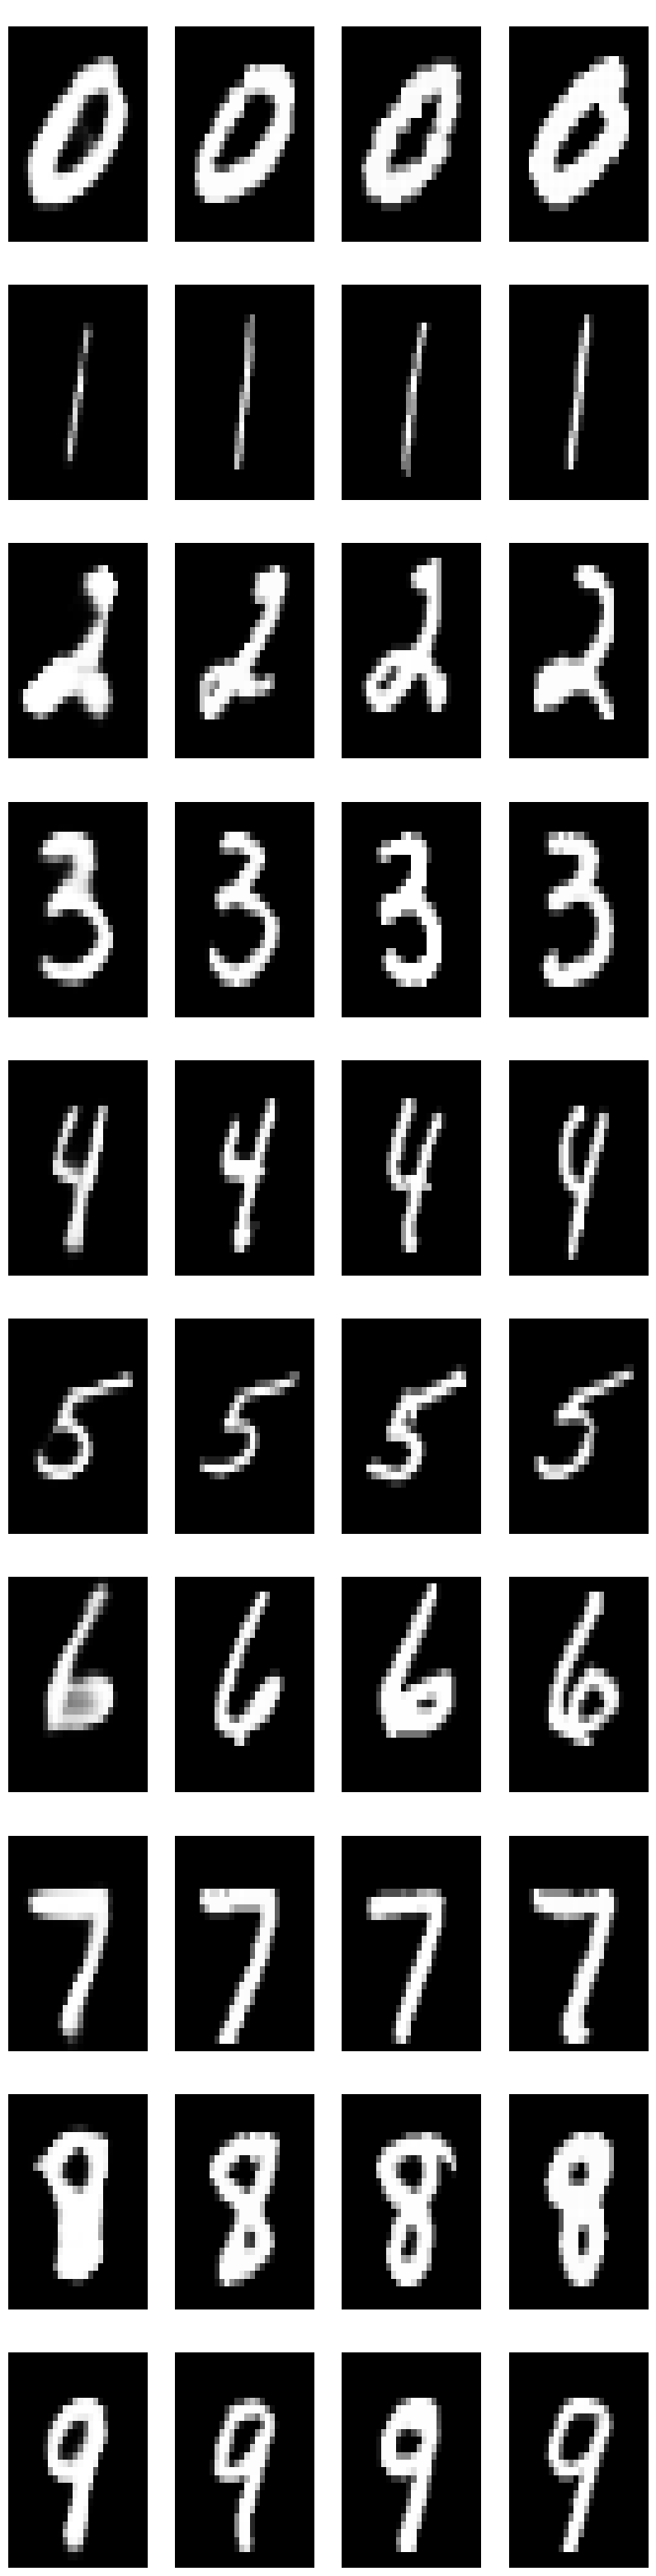

In [58]:
from random import randint
from einops import rearrange
from animation.util import backtransform_weights, reconstruct_image
from networks.mlp_models import MLP3D
from utils.metrics import pairwise_ssim_distance

# GENERATE WITH CLOSEST NEIGHBORS

# where 3 is 
num_neighbors = 3
width = 1 + num_neighbors
height = 10
# Plotting the tensors as heatmaps in grayscale
plt.style.use("dark_background")
fig, axes = plt.subplots(height, width, figsize=(10, 40))

fig.patch.set_alpha(0)

for ax in axes.flat:
    ax.patch.set_facecolor("none")
    ax.patch.set_alpha(0)


kwargs = {
"type": "pretrained",
"fixed_label": None,
}

for label in range(height):

    model.eval()
    novel_tokens = model.generate(torch.Tensor([[token_dict["SOS"], token_dict[str(label)]]]).long().to(device="cuda"), dataset[0][0].shape[0], temperature=0.87345, top_k=1)[:, 1:]

    print(label)
    novel_tokens = novel_tokens[:, 1:].unsqueeze(-1).to("cpu")
                                                                                                                        
    #print(f"Maximum Similarity of picture (i, j) {(i, j)}: {max_similarity}")

    novel_weights= vq.get_codes_from_indices((novel_tokens))

    dataset_no_transform = MnistNeFDataset(os.path.join(data_root, "datasets", "mnist-nerfs"), **kwargs)
    original_dict = dataset_no_transform[0][0]

    reconstructed_dict = backtransform_weights(novel_weights, original_dict["state_dict"])

    mlp3d = MLP3D(**original_dict["model_config"])
    mlp3d.load_state_dict(reconstructed_dict)
    reconstructed_tensor = torch.Tensor(rearrange( reconstruct_image(mlp3d), "... -> 1 1 ..."))

    # now find the closest neighbor regarding the ssim_distance
    distances = pairwise_ssim_distance(reconstructed_tensor, mnist[label])

    closest = torch.sort(distances).indices[:, -num_neighbors:]

    for i in range(num_neighbors):
        closest_neighbor = mnist[label][closest[:, -(i+1)].item()]

        axes[label][i + 1].imshow(closest_neighbor.squeeze(0), cmap='gray', aspect='auto')
        axes[label][i + 1].set_title(f"Nearest Neighbor {i + 1}")
        axes[label][i + 1].axis("off")

    axes[label][0].imshow(rearrange(reconstructed_tensor, "1 1 w h -> w h"), cmap='gray', aspect='auto')
    axes[label][0].set_title(f"Novel")
    axes[label][0].axis("off")

fig.patch.set_alpha(0)


plt.show()

In [ ]:
from training.mnist_classifier_score import compute_mnist_score
acc, loss= compute_mnist_score(model, vq, "cuda", token_dict)

print(acc)
print(loss)


0.703125
1.2872538566589355


In [ ]:
# script to 

In [ ]:
from utils.metrics import compute_all_metrics

reference =

compute_all_metrics()

In [43]:
# get the logits of the gpt model generation
model.eval()
logits_conditioning = model.generate_logits(torch.Tensor([[token_dict["SOS"]]]).long().to(device="cuda"))

# do a whole autoregressive proccess and get the logits for the last token
novel_tokens = model.generate(torch.Tensor([[token_dict["SOS"]]]).long().to(device="cuda"), dataset[0][0].shape[0] + 1, temperature=0.8, top_k=3)[:, :]
logits_last = model.generate_logits(novel_tokens[:, :-1])

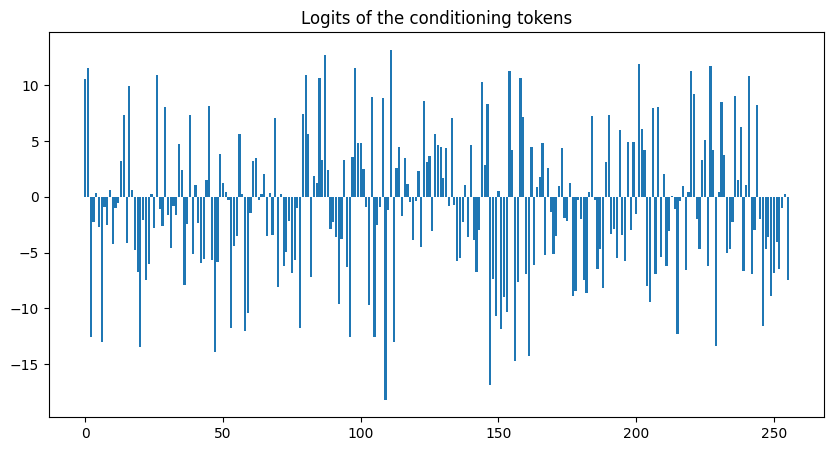

In [44]:
# barchart of the logits
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(range(logits_last.shape[-1]), logits_last[0].detach().cpu().numpy())
ax.set_title("Logits of the conditioning tokens")
plt.show()

In [ ]:
logits

In [ ]:
# store the logits as numpy file
import numpy as np
np.save("logits_conditioning.npy", logits_conditioning.squeeze(0).detach().cpu().numpy())
np.save("logits_last.npy", logits_last.squeeze(0).detach().cpu().numpy())

Text(0.5, 1.0, 'Softmax of the logits of the conditioning tokens')

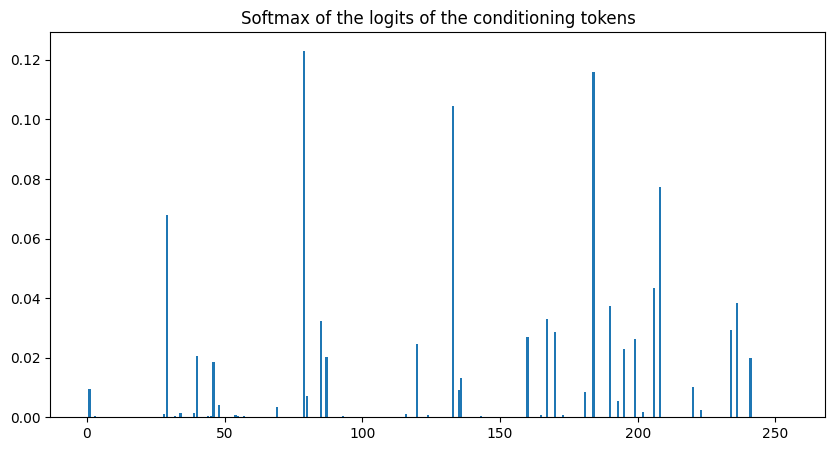

In [ ]:
# softmax of the logits conditioning
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
temperature = 2
logits = logits_last / temperature
ax.bar(range(logits_last.shape[-1]), torch.softmax(logits[0], dim=-1).detach().cpu().numpy())
ax.set_title("Softmax of the logits of the conditioning tokens")

In [ ]:
import optimize_metrics

optimize_metrics.main()

number of parameters: 5.62M
{'1': {'1': {'acc': 0.65625, 'loss': 1.4447228908538818}}}


{'1': {'1': {'acc': 0.65625, 'loss': 1.4447228908538818}}}